<a href="https://www.kaggle.com/code/chizkidd/microgpt?scriptVersionId=298496850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Karparthy's microGPT version
---

In his own words per his [blog](https://karpathy.github.io/):

>_This is a brief guide to my new art project microgpt, a single file of 200 lines of pure Python with no dependencies that trains and inferences a GPT. This file contains the full algorithmic content of what is needed: dataset of documents, tokenizer, autograd engine, a GPT-2-like neural network architecture, the Adam optimizer, training loop, and inference loop. Everything else is just efficiency. I cannot simplify this any further. This script is the culmination of multiple projects (micrograd, makemore, nanogpt, etc.) and a decade-long obsession to simplify LLMs to their bare essentials, and I think it is beautiful 🥹_

- Tweet: https://x.com/karpathy/status/2021694437152157847
- Blog: https://karpathy.github.io/2026/02/12/microgpt/
- Code: https://gist.github.com/karpathy/8627fe009c40f57531cb18360106ce95

In [1]:
"""
The most atomic way to train and inference a GPT in pure, dependency-free Python.
This file is the complete algorithm.
Everything else is just efficiency.

@karpathy
"""

import os       # os.path.exists
import math     # math.log, math.exp
import random   # random.seed, random.choices, random.gauss, random.shuffle
random.seed(42) # Let there be order among chaos

# Let there be an input dataset `docs`: list[str] of documents (e.g. a dataset of names)
if not os.path.exists('input.txt'):
    import urllib.request
    names_url = 'https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt'
    urllib.request.urlretrieve(names_url, 'input.txt')
docs = [l.strip() for l in open('input.txt').read().strip().split('\n') if l.strip()] # list[str] of documents
random.shuffle(docs)
print(f"num docs: {len(docs)}")

# Let there be a Tokenizer to translate strings to discrete symbols and back
uchars = sorted(set(''.join(docs))) # unique characters in the dataset become token ids 0..n-1
BOS = len(uchars) # token id for the special Beginning of Sequence (BOS) token
vocab_size = len(uchars) + 1 # total number of unique tokens, +1 is for BOS
print(f"vocab size: {vocab_size}")

# Let there be Autograd, to recursively apply the chain rule through a computation graph
class Value:
    __slots__ = ('data', 'grad', '_children', '_local_grads') # Python optimization for memory usage

    def __init__(self, data, children=(), local_grads=()):
        self.data = data                # scalar value of this node calculated during forward pass
        self.grad = 0                   # derivative of the loss w.r.t. this node, calculated in backward pass
        self._children = children       # children of this node in the computation graph
        self._local_grads = local_grads # local derivative of this node w.r.t. its children

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data + other.data, (self, other), (1, 1))

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data * other.data, (self, other), (other.data, self.data))

    def __pow__(self, other): return Value(self.data**other, (self,), (other * self.data**(other-1),))
    def log(self): return Value(math.log(self.data), (self,), (1/self.data,))
    def exp(self): return Value(math.exp(self.data), (self,), (math.exp(self.data),))
    def relu(self): return Value(max(0, self.data), (self,), (float(self.data > 0),))
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other): return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            for child, local_grad in zip(v._children, v._local_grads):
                child.grad += local_grad * v.grad

# Initialize the parameters, to store the knowledge of the model.
n_embd = 16     # embedding dimension
n_head = 4      # number of attention heads
n_layer = 1     # number of layers
block_size = 16 # maximum sequence length
head_dim = n_embd // n_head # dimension of each head
matrix = lambda nout, nin, std=0.08: [[Value(random.gauss(0, std)) for _ in range(nin)] for _ in range(nout)]
state_dict = {'wte': matrix(vocab_size, n_embd), 'wpe': matrix(block_size, n_embd), 'lm_head': matrix(vocab_size, n_embd)}
for i in range(n_layer):
    state_dict[f'layer{i}.attn_wq'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wk'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wv'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wo'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.mlp_fc1'] = matrix(4 * n_embd, n_embd)
    state_dict[f'layer{i}.mlp_fc2'] = matrix(n_embd, 4 * n_embd)
params = [p for mat in state_dict.values() for row in mat for p in row] # flatten params into a single list[Value]
print(f"num params: {len(params)}")

# Define the model architecture: a stateless function mapping token sequence and parameters to logits over what comes next.
# Follow GPT-2, blessed among the GPTs, with minor differences: layernorm -> rmsnorm, no biases, GeLU -> ReLU
def linear(x, w):
    return [sum(wi * xi for wi, xi in zip(wo, x)) for wo in w]

def softmax(logits):
    max_val = max(val.data for val in logits)
    exps = [(val - max_val).exp() for val in logits]
    total = sum(exps)
    return [e / total for e in exps]

def rmsnorm(x):
    ms = sum(xi * xi for xi in x) / len(x)
    scale = (ms + 1e-5) ** -0.5
    return [xi * scale for xi in x]

def gpt(token_id, pos_id, keys, values):
    tok_emb = state_dict['wte'][token_id] # token embedding
    pos_emb = state_dict['wpe'][pos_id] # position embedding
    x = [t + p for t, p in zip(tok_emb, pos_emb)] # joint token and position embedding
    x = rmsnorm(x)

    for li in range(n_layer):
        # 1) Multi-head attention block
        x_residual = x
        x = rmsnorm(x)
        q = linear(x, state_dict[f'layer{li}.attn_wq'])
        k = linear(x, state_dict[f'layer{li}.attn_wk'])
        v = linear(x, state_dict[f'layer{li}.attn_wv'])
        keys[li].append(k)
        values[li].append(v)
        x_attn = []
        for h in range(n_head):
            hs = h * head_dim
            q_h = q[hs:hs+head_dim]
            k_h = [ki[hs:hs+head_dim] for ki in keys[li]]
            v_h = [vi[hs:hs+head_dim] for vi in values[li]]
            attn_logits = [sum(q_h[j] * k_h[t][j] for j in range(head_dim)) / head_dim**0.5 for t in range(len(k_h))]
            attn_weights = softmax(attn_logits)
            head_out = [sum(attn_weights[t] * v_h[t][j] for t in range(len(v_h))) for j in range(head_dim)]
            x_attn.extend(head_out)
        x = linear(x_attn, state_dict[f'layer{li}.attn_wo'])
        x = [a + b for a, b in zip(x, x_residual)]
        # 2) MLP block
        x_residual = x
        x = rmsnorm(x)
        x = linear(x, state_dict[f'layer{li}.mlp_fc1'])
        x = [xi.relu() for xi in x]
        x = linear(x, state_dict[f'layer{li}.mlp_fc2'])
        x = [a + b for a, b in zip(x, x_residual)]

    logits = linear(x, state_dict['lm_head'])
    return logits

# Let there be Adam, the blessed optimizer and its buffers
learning_rate, beta1, beta2, eps_adam = 0.01, 0.85, 0.99, 1e-8
m = [0.0] * len(params) # first moment buffer
v = [0.0] * len(params) # second moment buffer

import time
train_start = time.time()
# Repeat in sequence
num_steps = 1000 # number of training steps
for step in range(num_steps):

    # Take single document, tokenize it, surround it with BOS special token on both sides
    doc = docs[step % len(docs)]
    tokens = [BOS] + [uchars.index(ch) for ch in doc] + [BOS]
    n = min(block_size, len(tokens) - 1)

    # Forward the token sequence through the model, building up the computation graph all the way to the loss.
    keys, values = [[] for _ in range(n_layer)], [[] for _ in range(n_layer)]
    losses = []
    for pos_id in range(n):
        token_id, target_id = tokens[pos_id], tokens[pos_id + 1]
        logits = gpt(token_id, pos_id, keys, values)
        probs = softmax(logits)
        loss_t = -probs[target_id].log()
        losses.append(loss_t)
    loss = (1 / n) * sum(losses) # final average loss over the document sequence. May yours be low.

    # Backward the loss, calculating the gradients with respect to all model parameters.
    loss.backward()

    # Adam optimizer update: update the model parameters based on the corresponding gradients.
    lr_t = learning_rate * (1 - step / num_steps) # linear learning rate decay
    for i, p in enumerate(params):
        m[i] = beta1 * m[i] + (1 - beta1) * p.grad
        v[i] = beta2 * v[i] + (1 - beta2) * p.grad ** 2
        m_hat = m[i] / (1 - beta1 ** (step + 1))
        v_hat = v[i] / (1 - beta2 ** (step + 1))
        p.data -= lr_t * m_hat / (v_hat ** 0.5 + eps_adam)
        p.grad = 0
        
    print_every = max(1, num_steps // 10)
    if (step + 1) % print_every == 0 or step == num_steps - 1:
        print(f"step {step+1:4d} / {num_steps:4d} | loss {loss.data:.4f}")
    # print(f"step {step+1:4d} / {num_steps:4d} | loss {loss.data:.4f}")

train_end = time.time()

# Inference: may the model babble back to us
temperature = 0.5 # in (0, 1], control the "creativity" of generated text, low to high
print("\n--- inference (new, hallucinated names) ---")
for sample_idx in range(20):
    keys, values = [[] for _ in range(n_layer)], [[] for _ in range(n_layer)]
    token_id = BOS
    sample = []
    for pos_id in range(block_size):
        logits = gpt(token_id, pos_id, keys, values)
        probs = softmax([l / temperature for l in logits])
        token_id = random.choices(range(vocab_size), weights=[p.data for p in probs])[0]
        if token_id == BOS:
            break
        sample.append(uchars[token_id])
    print(f"sample {sample_idx+1:2d}: {''.join(sample)}")


final_end = time.time()

print(f"train start:  {time.strftime('%H:%M:%S', time.localtime(train_start))}")
print(f"train end:    {time.strftime('%H:%M:%S', time.localtime(train_end))}")
print(f"final end:    {time.strftime('%H:%M:%S', time.localtime(final_end))}")
print(f"train time:   {train_end - train_start:.1f}s  ({(train_end - train_start)/60:.1f} min)")
print(f"total time:   {final_end - train_start:.1f}s  ({(final_end - train_start)/60:.1f} min)")

num docs: 32033
vocab size: 27
num params: 4192
step  100 / 1000 | loss 3.3669
step  200 / 1000 | loss 2.3097
step  300 / 1000 | loss 2.3178
step  400 / 1000 | loss 2.3428
step  500 / 1000 | loss 2.0645
step  600 / 1000 | loss 2.4851
step  700 / 1000 | loss 2.3357
step  800 / 1000 | loss 2.2632
step  900 / 1000 | loss 2.7785
step 1000 / 1000 | loss 2.6497

--- inference (new, hallucinated names) ---
sample  1: kamon
sample  2: ann
sample  3: karai
sample  4: jaire
sample  5: vialan
sample  6: karia
sample  7: yeran
sample  8: anna
sample  9: areli
sample 10: kaina
sample 11: konna
sample 12: keylen
sample 13: liole
sample 14: alerin
sample 15: earan
sample 16: lenne
sample 17: kana
sample 18: lara
sample 19: alela
sample 20: anton
train start:  14:58:33
train end:    15:02:36
final end:    15:02:38
train time:   242.1s  (4.0 min)
total time:   244.2s  (4.1 min)


## **total time: approx. 4.1 mins**

# 2. My microGPT version: **~8X faster than Karpathy's**
---

Project can be found on [GitHub](https://github.com/chizkidd/microGPT/blob/main/run_microgpt.py). I made improvements to the [Karpathy version](https://x.com/karpathy/status/2021694437152157847):

1. PyTorch/GPU port with multi-dataset runner
2. Gradient clipping
3. EMA loss smoothing
4. Train/val split (90/10)
5. Top-k sampling
6. Seeded `generate(prompt)`
7. Checkpointing (save/resume)
8. Live loss plots (train raw, EMA, val)
9. 10-line progress logging per dataset
10. Stream vs discrete inference mode
11. Full CLI — all hyperparameters overridable from command line (`--n-embd`, `--lr`, `--beta1`, `--beta2`, `--steps` and more)

>Datasets: names, Pokémon, cities, English words, Paul Graham essays, Shakespeare.



In [2]:
# !find /kaggle/input/models/chizkidd -type f

In [3]:
train_start = time.time()

# !cp /kaggle/input/models/chizkidd/run-microgpt-v2-py/pytorch/default/1/run_microgpt3.py /kaggle/working/
# !python /kaggle/working/run_microgpt3.py \

!cp /kaggle/input/models/chizkidd/microgpt/pytorch/default/1/microgpt.py /kaggle/working/
!python /kaggle/working/microgpt.py \
    --only names \
    --n-embd 16 \
    --n-head 4 \
    --n-layer 1 \
    --block-size 16 \
    --lr 0.01 \
    --beta1 0.85 \
    --beta2 0.99 \
    --eps 1e-8 \
    --steps 1000 \
    --no-plot


final_end = time.time()

print(f"train start:  {time.strftime('%H:%M:%S', time.localtime(train_start))}")
# print(f"train end:    {time.strftime('%H:%M:%S', time.localtime(train_end))}")
print(f"final end:    {time.strftime('%H:%M:%S', time.localtime(final_end))}")
# print(f"train time:   {train_end - train_start:.1f}s  ({(train_end - train_start)/60:.1f} min)")
print(f"total time:   {final_end - train_start:.1f}s  ({(final_end - train_start)/60:.1f} min)")

running 1 dataset(s): ['names']
cli overrides: {'steps': 1000, 'n_embd': 16, 'n_layer': 1, 'n_head': 4, 'block_size': 16, 'lr': 0.01, 'beta1': 0.85, 'beta2': 0.99, 'eps': 1e-08, 'no_plot': True}

  Dataset : names
  Note    : Baby names -- the original benchmark
  Steps   : 1000  |  n_embd=16  n_layer=1  n_head=4
device: cuda
  [download] https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
  [saved]  datasets/names.txt
num docs: 32033
train: 28829  |  val: 3204
vocab size: 27
num params: 4,224
  [names] step  100/1000 ( 10%)  loss 3.2984  ema 2.7300  val 2.7650
  [names] step  200/1000 ( 20%)  loss 2.3922  ema 2.5703  val 2.4694
  [names] step  300/1000 ( 30%)  loss 2.4642  ema 2.4706  val 2.6220
  [names] step  400/1000 ( 40%)  loss 2.4347  ema 2.5199  val 2.5021
  [names] step  500/1000 ( 50%)  loss 1.9637  ema 2.4574  val 2.5669
  [names] step  600/1000 ( 60%)  loss 2.4858  ema 2.4661  val 2.4196
  [names] step  700/1000 ( 70%)  loss 2.2220  ema 2.4157  v

## **total time: approx. 0.5 mins**

## 2.1. All Datasets

In [4]:
start = time.time()

# !cp /kaggle/input/models/chizkidd/run-microgpt-v2-py/pytorch/default/1/run_microgpt3.py /kaggle/working/run_microgpt.py
# !python /kaggle/working/run_microgpt.py --only paul_graham --steps 100000

!cp /kaggle/input/models/chizkidd/microgpt/pytorch/default/1/microgpt.py /kaggle/working/
!python /kaggle/working/microgpt.py 

end = time.time()

print(f"start:   {time.strftime('%H:%M:%S', time.localtime(start))}")
print(f"end:     {time.strftime('%H:%M:%S', time.localtime(end))}")
print(f"elapsed: {end - start:.1f}s  ({(end - start)/60:.1f} min)")

running 6 dataset(s): ['pokemon', 'paul_graham', 'cities', 'names', 'english_words', 'shakespeare']

  Dataset : pokemon
  Note    : Pokemon names -- short sequences, fast to learn
  Steps   : 1000  |  n_embd=32  n_layer=2  n_head=4
device: cuda
  [download] https://raw.githubusercontent.com/veekun/pokedex/master/pokedex/data/csv/pokemon.csv
  [saved]  datasets/pokemon.txt
num docs: 1092
train: 982  |  val: 110
vocab size: 28
num params: 26,880
  [pokemon] step  100/1000 ( 10%)  loss 3.2960  ema 3.0171  val 2.8996
  [pokemon] step  200/1000 ( 20%)  loss 3.0758  ema 2.8505  val 2.7365
  [pokemon] step  300/1000 ( 30%)  loss 2.6612  ema 2.8486  val 2.7842
  [pokemon] step  400/1000 ( 40%)  loss 2.8230  ema 2.7778  val 2.7416
  [pokemon] step  500/1000 ( 50%)  loss 2.8172  ema 2.7405  val 2.6332
  [pokemon] step  600/1000 ( 60%)  loss 1.6031  ema 2.6049  val 2.6767
  [pokemon] step  700/1000 ( 70%)  loss 2.7279  ema 2.6516  val 2.8122
  [pokemon] step  800/1000 ( 80%)  loss 2.4838  ema 2.

In [5]:
import shutil

shutil.make_archive('/kaggle/working/outputs', 'zip', '/kaggle/working', 'outputs')

'/kaggle/working/outputs.zip'

/kaggle/working/outputs/cities/cities_e32_l2_h4_s3000_train_ema_val.png


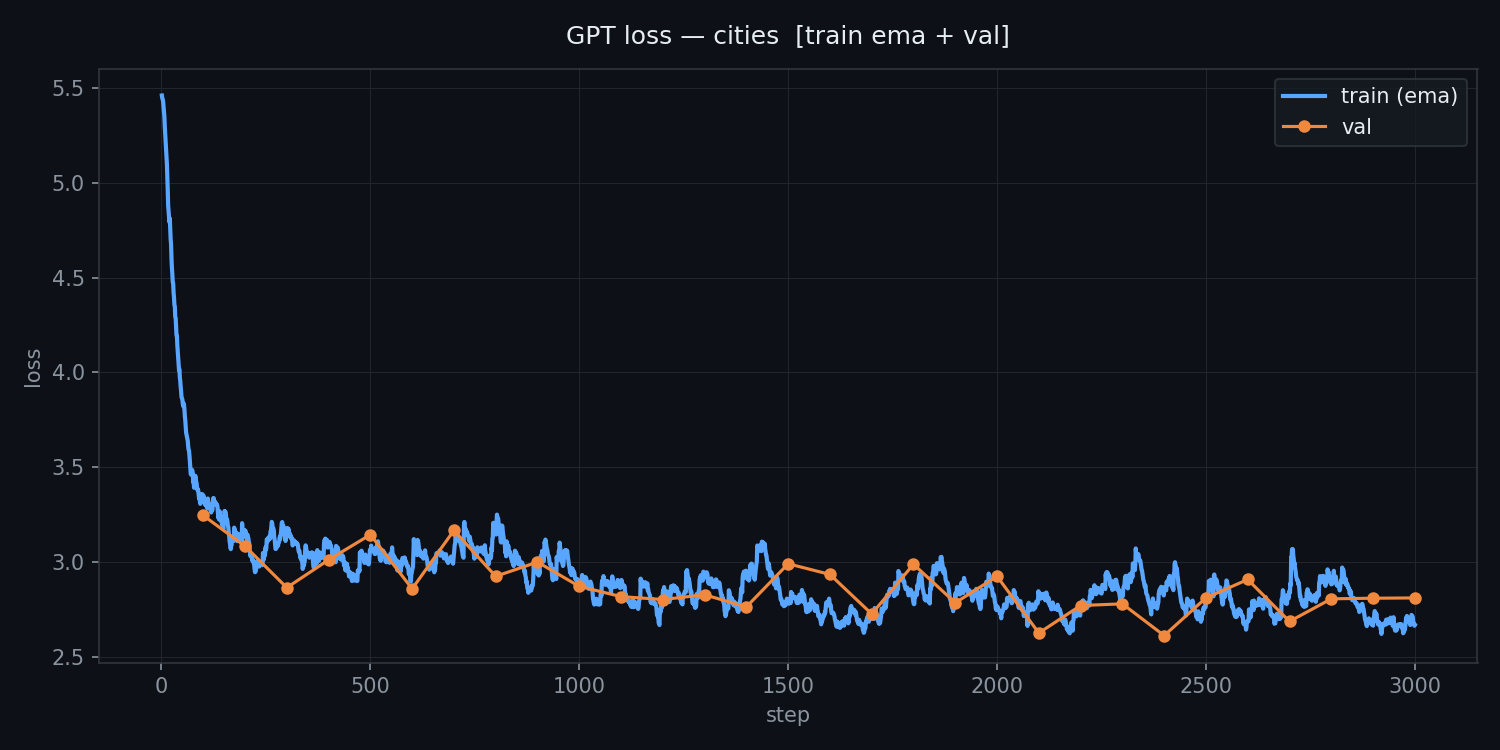

/kaggle/working/outputs/english_words/english_words_e32_l2_h4_s3000_train_ema_val.png


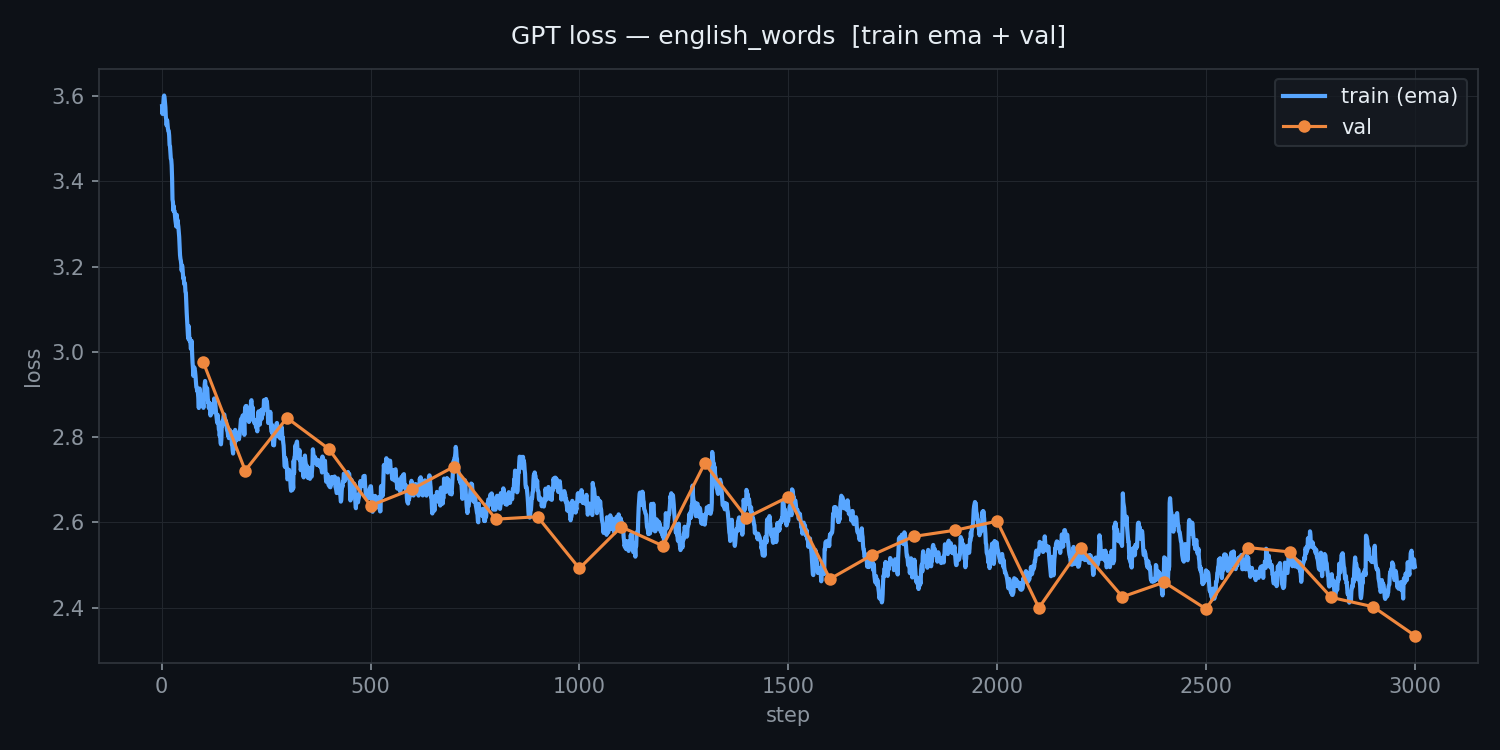

/kaggle/working/outputs/names/names_e16_l1_h4_s2000_train_ema_val.png


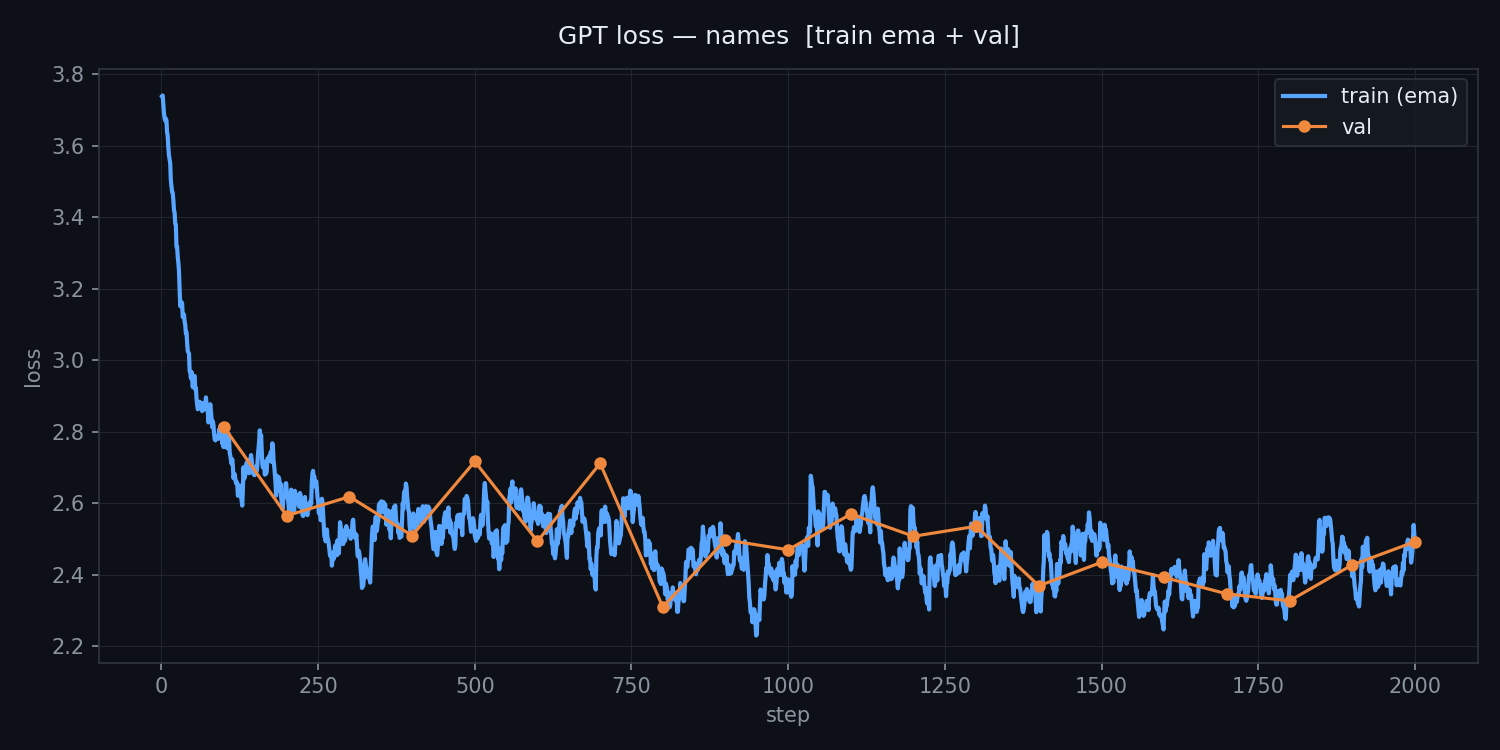

/kaggle/working/outputs/paul_graham/paul_graham_e64_l4_h4_s5000_train_ema_val.png


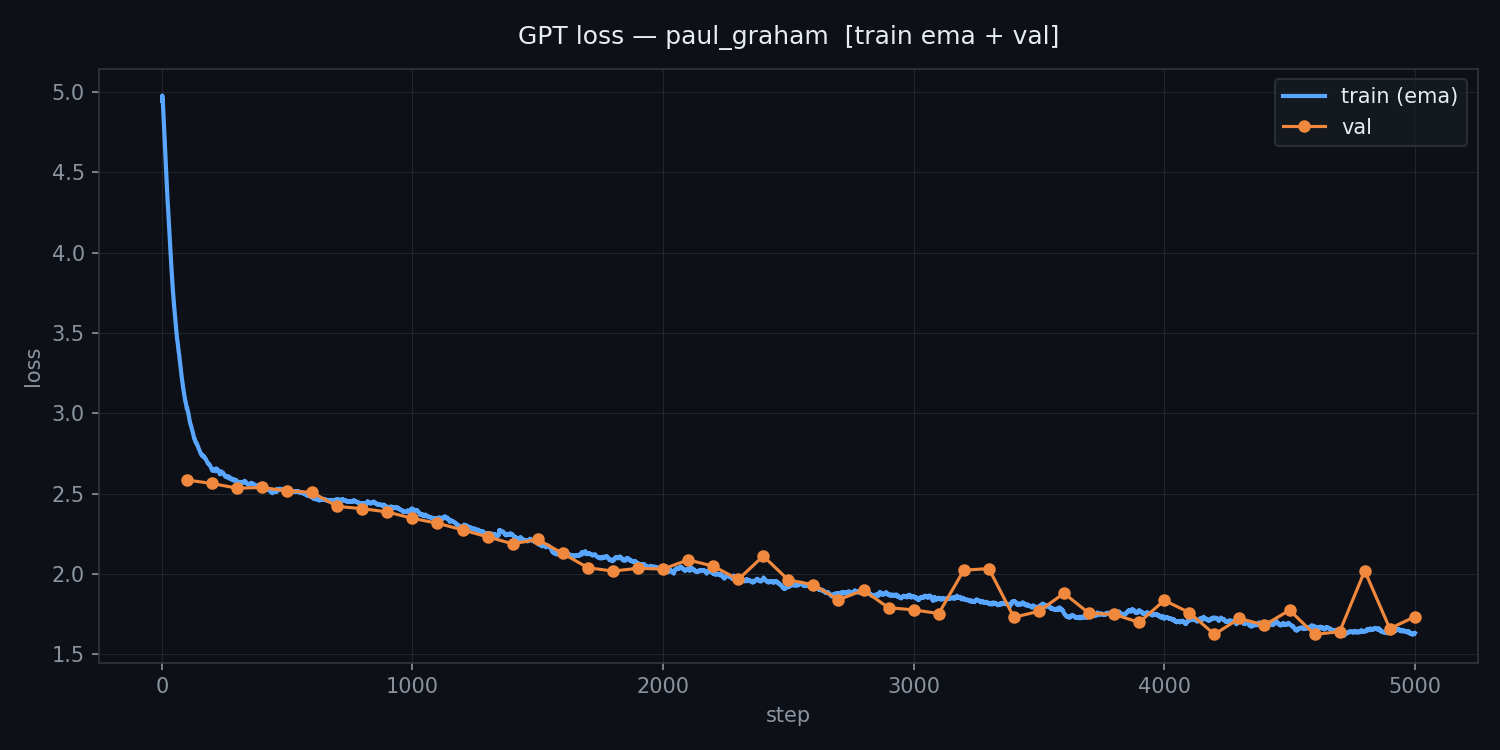

/kaggle/working/outputs/pokemon/pokemon_e32_l2_h4_s1000_train_ema_val.png


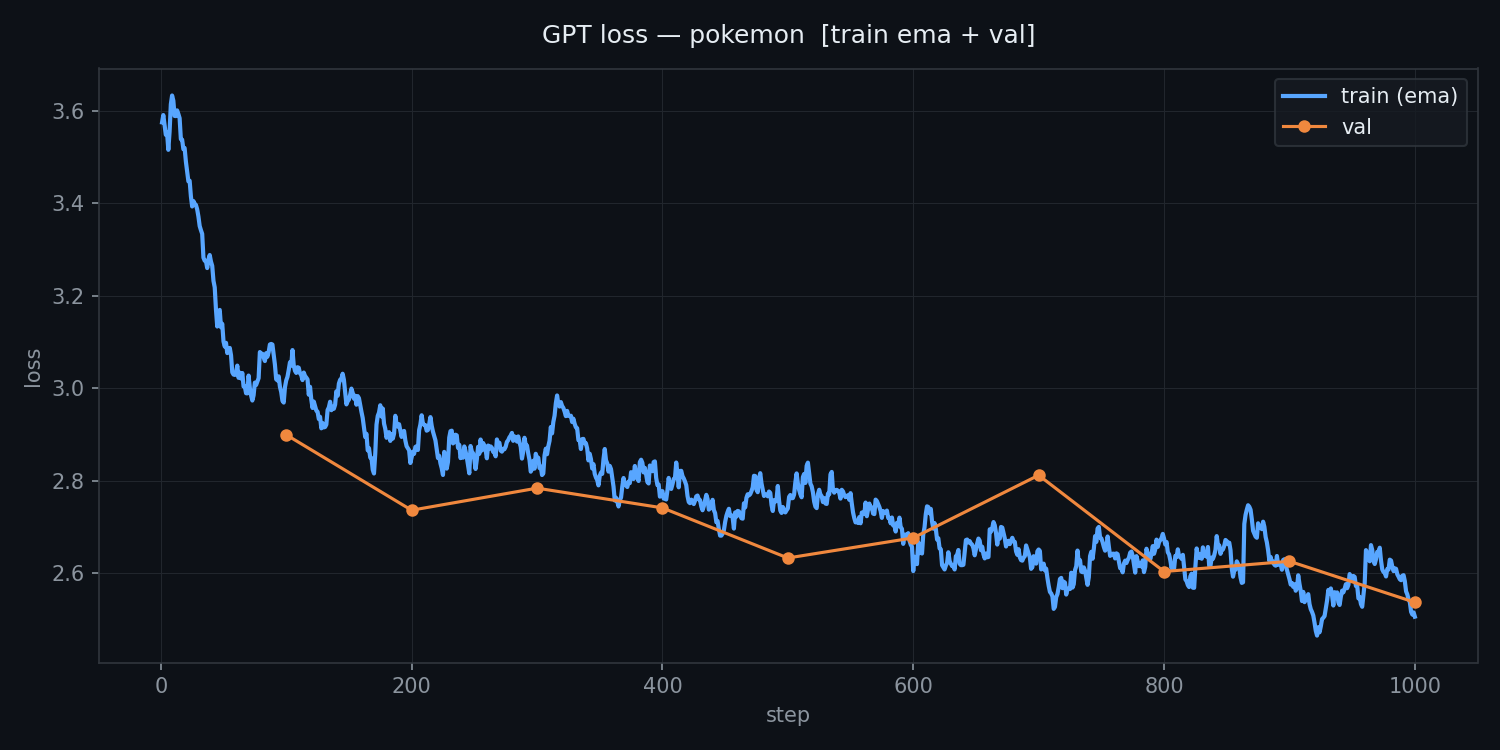

/kaggle/working/outputs/shakespeare/shakespeare_e64_l4_h4_s5000_train_ema_val.png


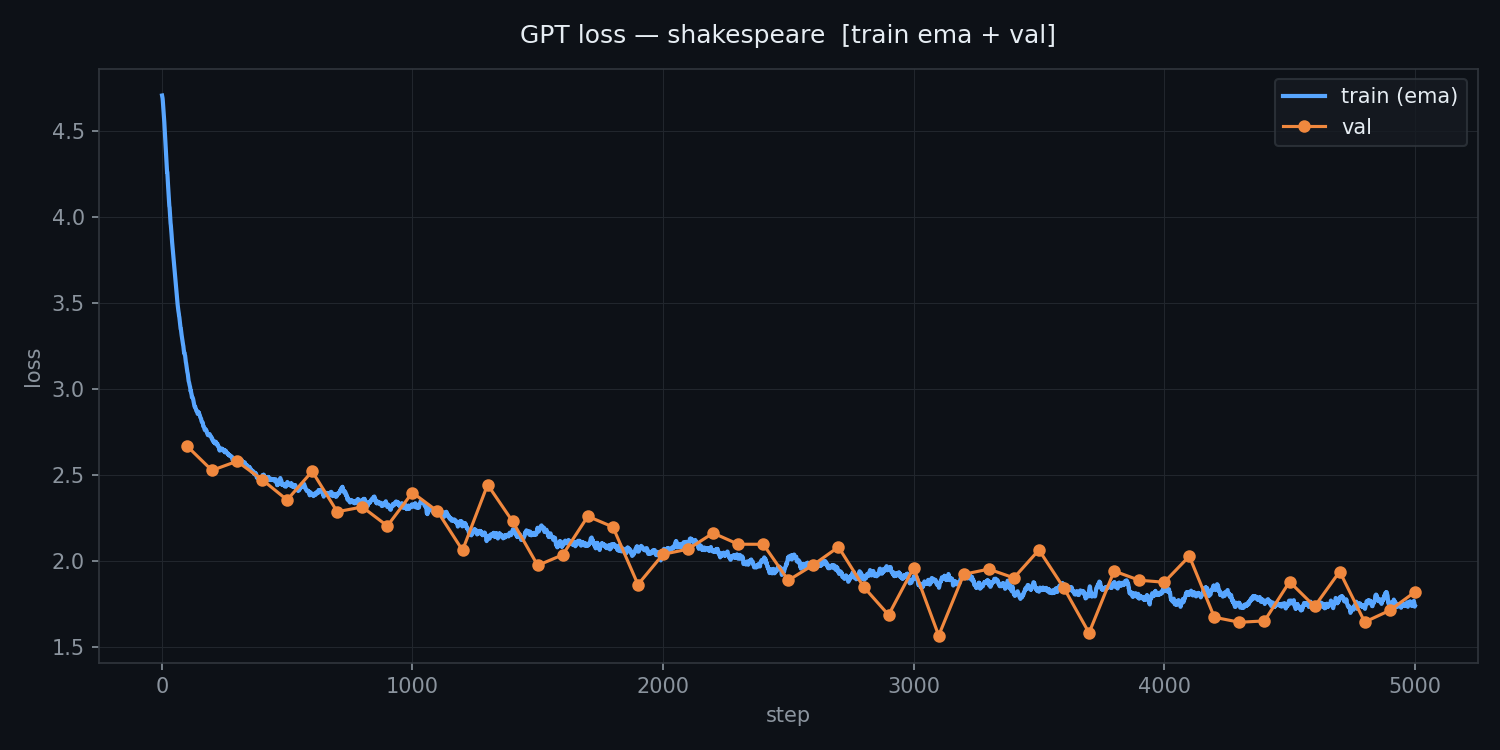

In [6]:
from IPython.display import Image, display
import glob

# per-dataset: train_ema_val only (exclude all_losses)
for p in sorted(glob.glob('/kaggle/working/outputs/**/*_train_ema_val.png', recursive=True)):
    if 'all_losses' not in p and p != '/kaggle/working/outputs/names/names_e16_l1_h4_s1000_train_ema_val.png':
        print(p)
        display(Image(p))

/kaggle/working/outputs/all_losses_20260218_151537_train_ema_val.png


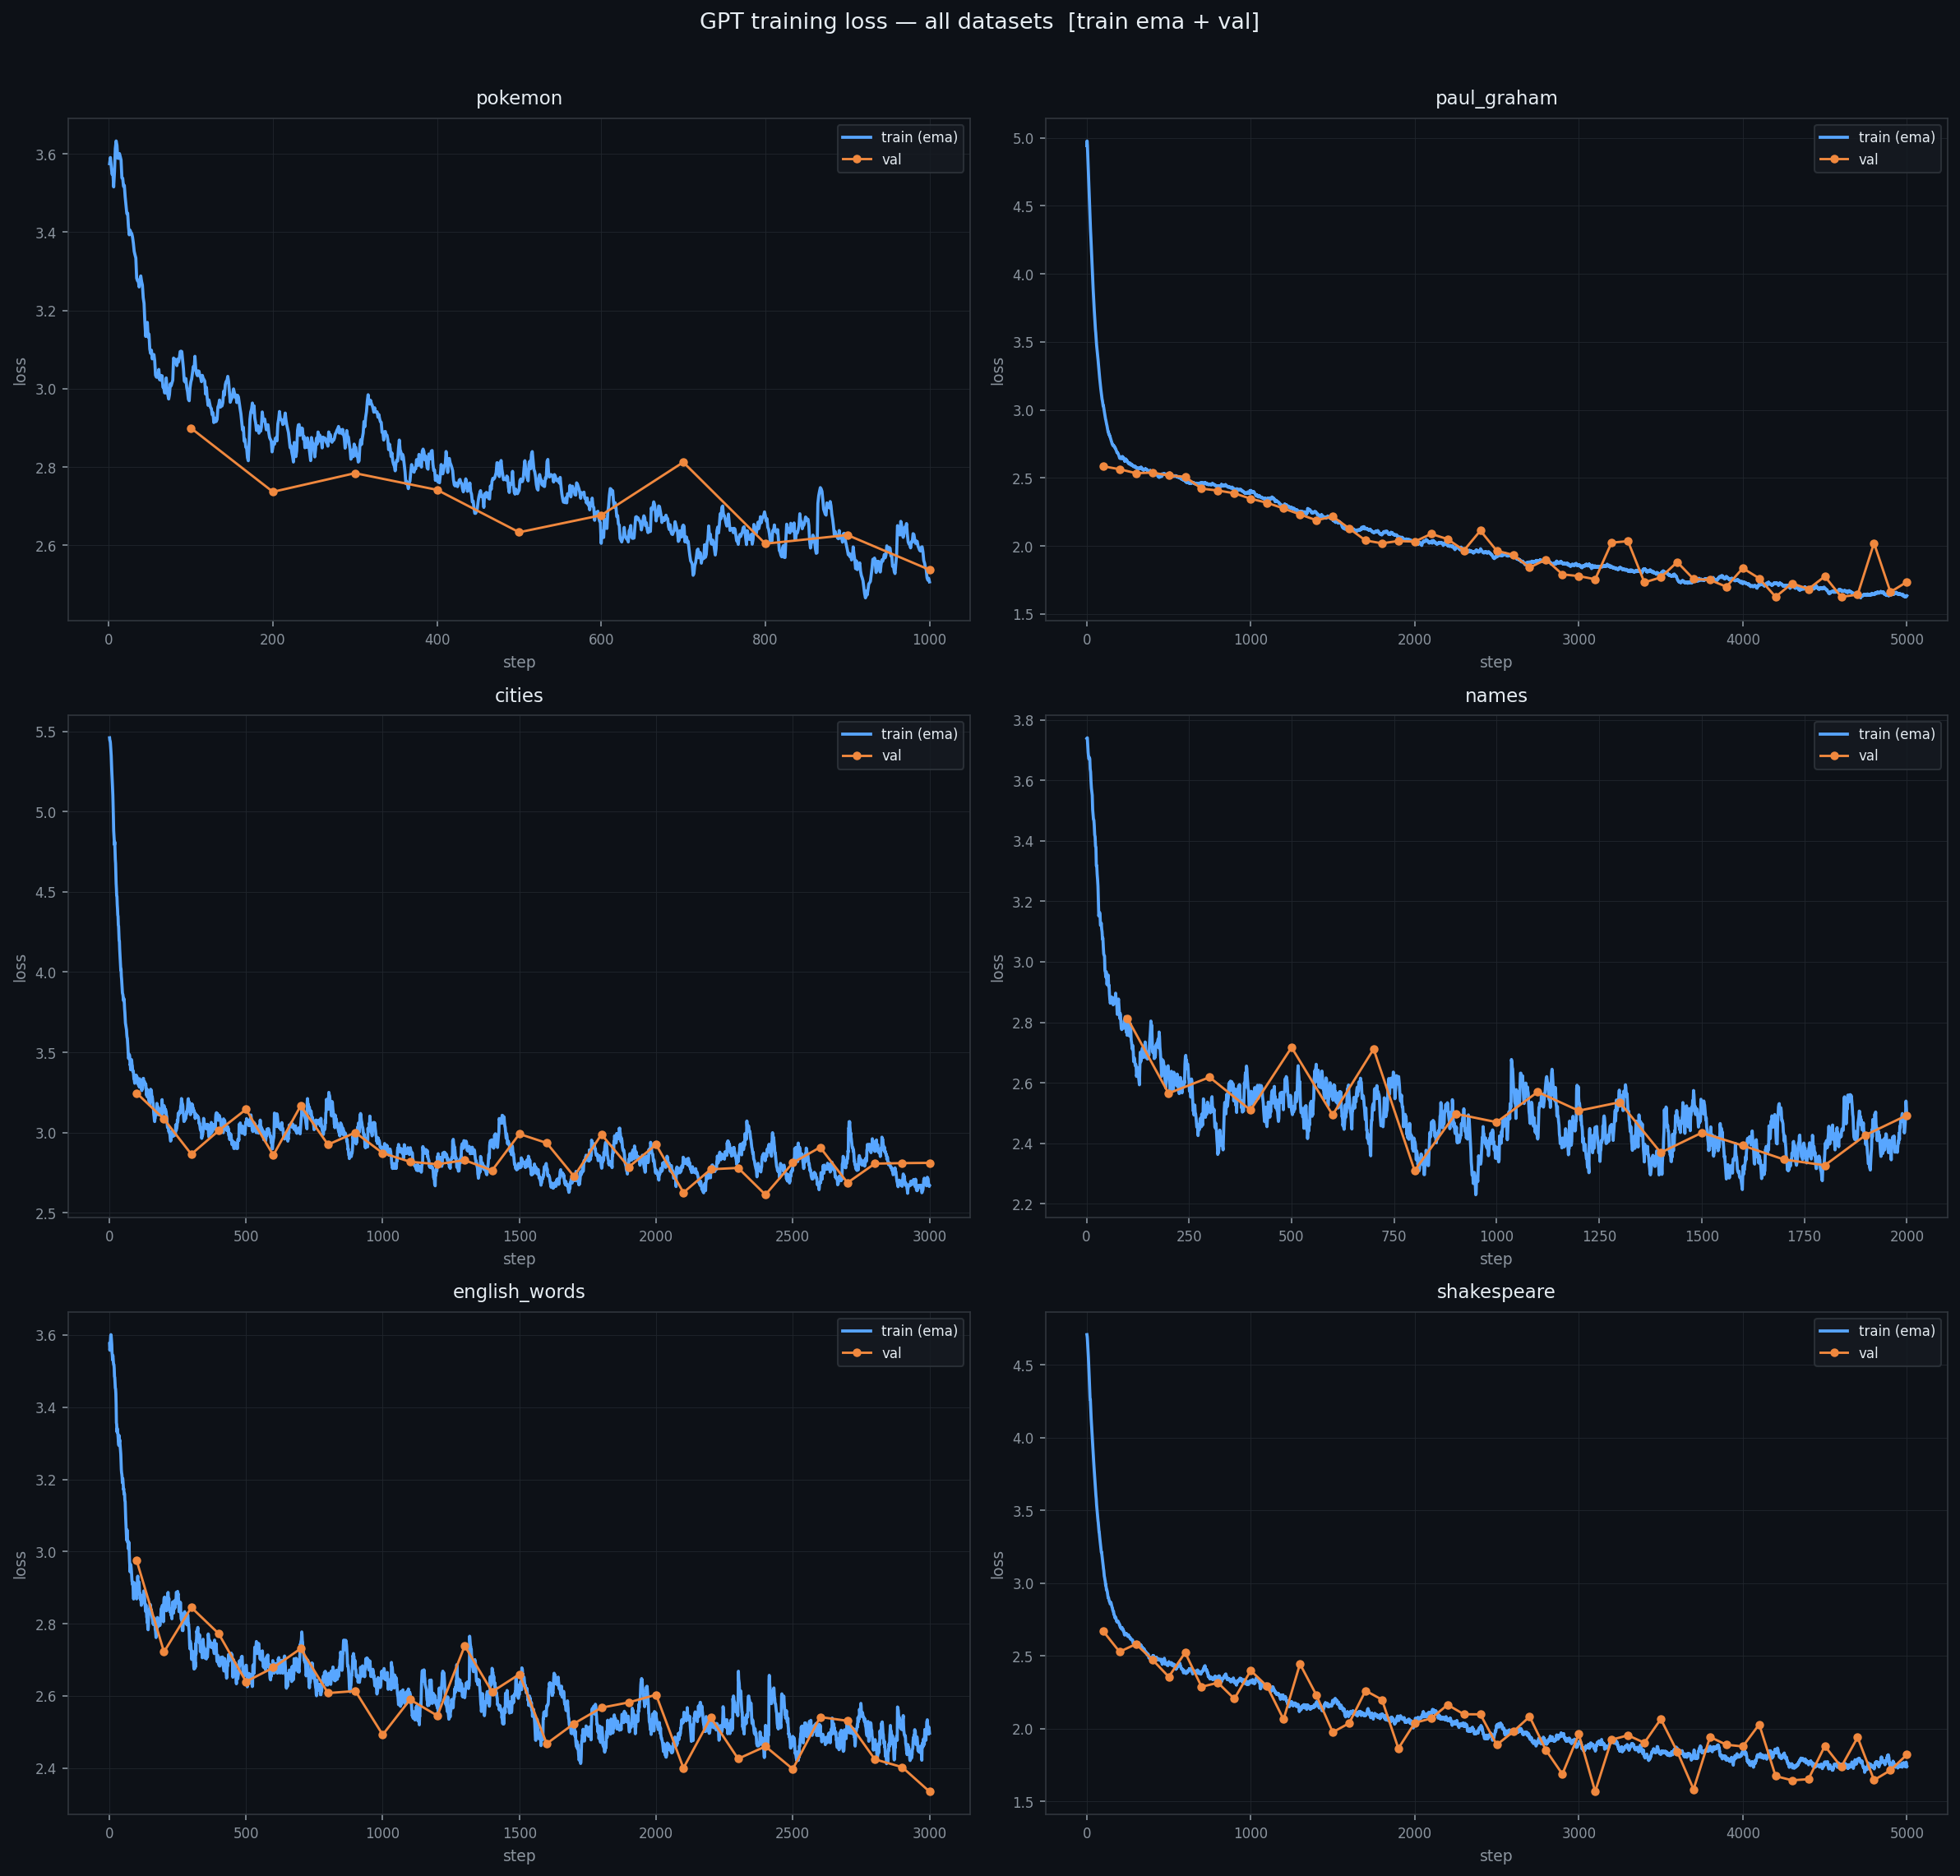

In [7]:
# combined all_losses
for p in sorted(glob.glob('/kaggle/working/outputs/all_losses_*_train_ema_val.png')):
    if p != '/kaggle/working/outputs/all_losses_20260215_104722_train_ema_val.png':
        print(p)
        display(Image(p))

## 2.2. Dataset: Paul Graham essays

In [8]:
start = time.time()

# !cp /kaggle/input/models/chizkidd/run-microgpt-v2-py/pytorch/default/1/run_microgpt3.py /kaggle/working/run_microgpt.py
# !python /kaggle/working/run_microgpt.py --only paul_graham --steps 100000

!cp /kaggle/input/models/chizkidd/microgpt/pytorch/default/1/microgpt.py /kaggle/working/
!python /kaggle/working/microgpt.py --only paul_graham --steps 250000

end = time.time()

print(f"start:   {time.strftime('%H:%M:%S', time.localtime(start))}")
print(f"end:     {time.strftime('%H:%M:%S', time.localtime(end))}")
print(f"elapsed: {end - start:.1f}s  ({(end - start)/60:.1f} min)")

running 1 dataset(s): ['paul_graham']
cli overrides: {'steps': 250000}

  Dataset : paul_graham
  Note    : Paul Graham essays (~200 txt files) -- distinctive prose style
  Steps   : 250000  |  n_embd=64  n_layer=4  n_head=4
device: cuda
  [cache]    datasets/paul_graham_essays/_pg_index.json  (218 files)
  loaded 9086 paragraphs from 218 PG essays
num docs: 9086
train: 8177  |  val: 909
vocab size: 103
num params: 218,496
  [paul_graham] step 25000/250000 ( 10%)  loss 1.8171  ema 1.5254  val 1.5560
  [paul_graham] step 50000/250000 ( 20%)  loss 1.4599  ema 1.4415  val 1.5032
  [paul_graham] step 75000/250000 ( 30%)  loss 1.5505  ema 1.3948  val 1.3727
  [paul_graham] step 100000/250000 ( 40%)  loss 1.1657  ema 1.3583  val 1.4009
  [paul_graham] step 125000/250000 ( 50%)  loss 1.3938  ema 1.3249  val 1.4921
  [paul_graham] step 150000/250000 ( 60%)  loss 0.7625  ema 1.2940  val 1.3700
  [paul_graham] step 175000/250000 ( 70%)  loss 1.1489  ema 1.2635  val 1.5500
  [paul_graham] step 20

In [10]:
!cp /kaggle/input/models/chizkidd/probe/pytorch/default/1/probe.py /kaggle/working/
!python /kaggle/working/probe.py --dataset paul_graham --stream --prompt "The best startups are built by"

device: cuda
loading checkpoint: outputs/paul_graham/ckpt.pt
config: n_embd=64 n_head=4 n_layer=4 block_size=128
vocab size: 103
num params: 218,496
[warn] no loss.png found -- run at least one val_every checkpoint to generate it

--- generating 5 sample(s) ---
    temperature=0.8  topk=0  stream=True  prompt='The best startups are built by'

--- sample 1 ---
The best startups are built by grades interested on their and money. Because of his back and idea was. It was for a startup inveVtinglaan see to leavn to sufetchatitingi aros worteest that somethan,e and anded seesuallsuag isous thaterst andred wholecfn isks and sometharian froll that any excutore thrusteal testsesesurgnin'nlnewiotad does you cand sorvoos are a situate mayfondst coming avotheps so one,uth in avolel in a startup,then anynaturly, and alstacttert, as ",", andredr anyping a stated less,tall,t met almot: beBen these,t leads 

--- sample 2 ---
The best startups are built by the problem is that responsible grading at the